# Objective: x% PDF as a function of m_hh

can we generate a PDF that would describe to use how much 2b-Together impurities to put into the 2b-Split model to best model the 4b to start with ?

In [1]:
#allows to reload modules properly
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm
import seaborn as sns
import uproot
from uproot_methods.classes.TLorentzVector import TLorentzVectorArray
import os
os.sys.path.append('../../')
import eda_tools
from eda_tools import nicole_tools as nt
from eda_tools import histogram_helper as hh
from eda_tools import utilities as u
from eda_tools import trigger_utilities as tu
from eda_tools import plot_helper as ph
from eda_tools import pyhf_models as pm
from loadNNT import loadNNT
from math import log10
from hepstats.modeling import bayesian_blocks
import pyhf
from pyhf import Model, optimizer
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras.backend as K

from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers.normalization import BatchNormalization
from eda_tools import NN_RW as nn

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [4]:
from eda_tools import bkg_helper as bh

In [5]:
f = uproot.open('/mnt/storage/lborgna/data/data17_NN_100_bootstraps_IQR.fmp.root')

In [18]:
df = f['fullmassplane'].pandas.df()

In [19]:
u.calculatedPhi(df)
u.calculatedRhh(df)

In [20]:
CR = df[df.kinematic_region ==2].reset_index(drop = True)

In [21]:
CRS = CR[u.splitMask(CR)]

In [22]:
CRT = CR[u.togetherMask(CR)]

In [23]:
(CR.ntag >= 4).value_counts()

False    1986579
True       29638
Name: ntag, dtype: int64

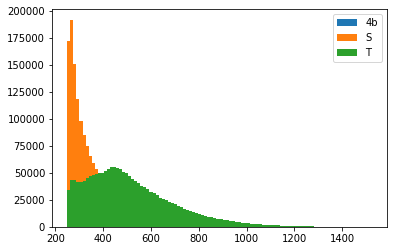

In [70]:
f4b, be, _ = plt.hist(CR[CR.ntag >=4].m_hh_cor, bins = 100, label = '4b')
N4b = np.sum(f4b)
mu = N4b/(len(CRS) + len(CRT))
muS = N4b/len(CRS)
muT = N4b/len(CRT)


h2bS, _, _ = plt.hist(CRS.m_hh_cor, bins = be, label = 'S', weights = muS/mu * np.ones(len(CRS)))
h2bT, _, _ = plt.hist(CRT.m_hh_cor, bins = be, label = 'T', weights = muT/mu * np.ones(len(CRT)))
plt.legend()

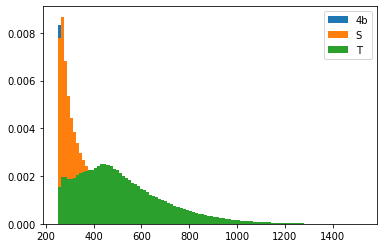

In [68]:
f4b, be, _ = plt.hist(CR[CR.ntag >=4].m_hh_cor, bins = 100, label = '4b', density = 1)
N4b = np.sum(f4b)
mu = N4b/(len(CRS) + len(CRT))

h2bS, _, _ = plt.hist(CRS.m_hh_cor, bins = be, label = 'S', density = 1)
h2bT, _, _ = plt.hist(CRT.m_hh_cor, bins = be, label = 'T', density = 1)
plt.legend()

In [57]:
fractions = np.linspace(0,1,21, endpoint = True)

In [58]:
fractions

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [79]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [80]:
viridis = cm.get_cmap('viridis', len(fractions))

In [86]:
cm = viridis(range(len(fractions)))

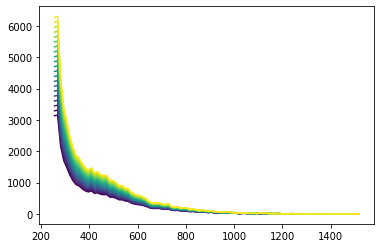

In [91]:
for i, fi in enumerate(fractions):
    plt.plot(x, f4b+ fi*f4b, color = cm[i])

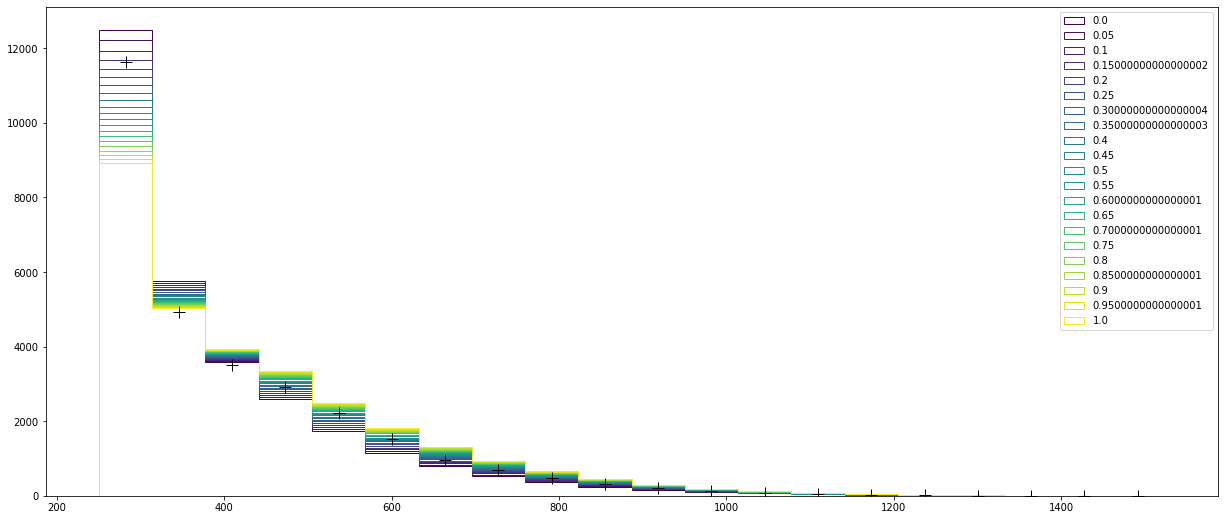

In [215]:
fig = plt.figure(figsize = (21,9))
f4b, be = np.histogram(CR[CR.ntag >=4].m_hh_cor, bins = 20)
x = hh.bin_midpoint(be)
plt.plot(x, f4b, 'k+', ms = 12)

N4b = np.sum(f4b)
mu = N4b/(len(CRS) + len(CRT))
muS = N4b/len(CRS)
muT = N4b/len(CRT)
mus = []
h2bM = np.zeros((len(fractions), len(f4b)))
for i, f in enumerate(fractions):
    M = u.mixSplitTogether(CRS, CRT, f = f)
    muM = N4b/len(M)
    mus.append(muM)
    h2bM[i], _ , _ = plt.hist(M.m_hh_cor, bins = be, color = cm[i], label = str(f), weights = muM * np.ones(len(M)), histtype = 'step')

#h2bS, _, _ = plt.hist(CRS.m_hh_cor, bins = be, label = 'S', weights = muS * np.ones(len(CRS)), histtype = 'step')
#h2bT, _, _ = plt.hist(CRT.m_hh_cor, bins = be, label = 'T', weights = muT * np.ones(len(CRT)), histtype = 'step')
plt.legend()

In [218]:
h2bM.shape

(21, 20)

In [219]:
diffM = np.zeros(h2bM.shape)

In [220]:
diffM[0, :] = np.nan_to_num((np.abs(f4b - h2bM[0, :]))/f4b, posinf=9999)

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [221]:
for i, _ in enumerate(fractions):
    diffM[i, :] = np.nan_to_num((np.abs(f4b - h2bM[i,:]))/ f4b, posinf=9999)

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [222]:
diffM[:,0].shape

(21,)

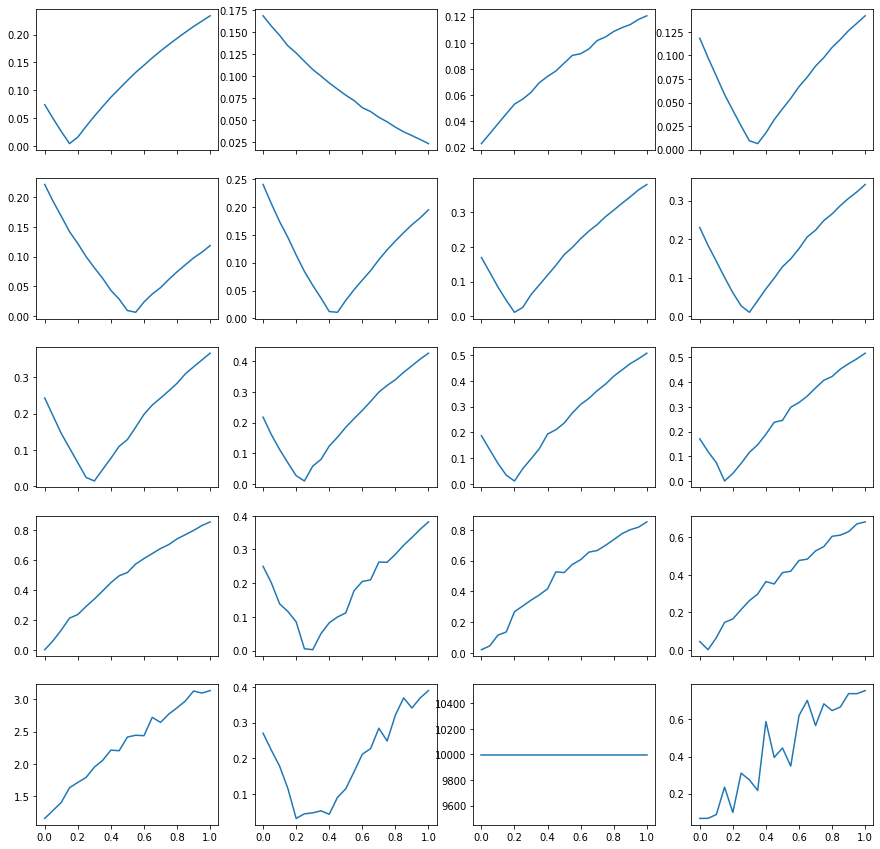

In [244]:
fig, axs = plt.subplots(5,4, sharex=True, figsize = (15, 15))

axs = axs.ravel()

for i in range(len(axs)):
    axs[i].plot(fractions, diffM[:, i])

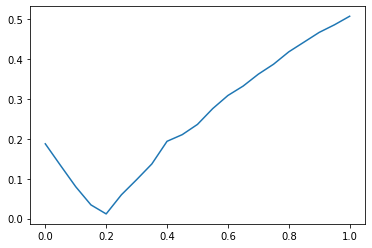

In [239]:
plt.plot(fractions, diffM[:,10])

In [224]:
diffM[0,:]

array([7.42965800e-02, 1.68945125e-01, 2.30374340e-02, 1.18297967e-01,
       2.21529749e-01, 2.40837279e-01, 1.69437066e-01, 2.30120430e-01,
       2.43380592e-01, 2.18070893e-01, 1.87677750e-01, 1.71207937e-01,
       2.80144152e-03, 2.49929346e-01, 2.14614156e-02, 4.47306838e-02,
       1.15827585e+00, 2.70521613e-01, 9.99900000e+03, 6.69462493e-02])

In [225]:
diffM[1,:]

array([4.97991075e-02, 1.57260295e-01, 3.05436206e-02, 9.76067556e-02,
       1.93483027e-01, 2.06440724e-01, 1.27223676e-01, 1.83707506e-01,
       1.94451985e-01, 1.61441466e-01, 1.33415023e-01, 1.19618024e-01,
       6.21816412e-02, 2.01059035e-01, 4.60712942e-02, 1.01865440e-03,
       1.28096699e+00, 2.22646451e-01, 9.99900000e+03, 6.74925494e-02])

In [226]:
fractions[np.where(diffM[:,52] == np.min(diffM[:,52]))][0]

IndexError: index 52 is out of bounds for axis 1 with size 20

In [227]:
a = np.where(diffM[:,52] == np.min(diffM[:,52], axis = 0))

IndexError: index 52 is out of bounds for axis 1 with size 20

In [245]:
diffM

array([[7.42965800e-02, 1.68945125e-01, 2.30374340e-02, 1.18297967e-01,
        2.21529749e-01, 2.40837279e-01, 1.69437066e-01, 2.30120430e-01,
        2.43380592e-01, 2.18070893e-01, 1.87677750e-01, 1.71207937e-01,
        2.80144152e-03, 2.49929346e-01, 2.14614156e-02, 4.47306838e-02,
        1.15827585e+00, 2.70521613e-01, 9.99900000e+03, 6.69462493e-02],
       [4.97991075e-02, 1.57260295e-01, 3.05436206e-02, 9.76067556e-02,
        1.93483027e-01, 2.06440724e-01, 1.27223676e-01, 1.83707506e-01,
        1.94451985e-01, 1.61441466e-01, 1.33415023e-01, 1.19618024e-01,
        6.21816412e-02, 2.01059035e-01, 4.60712942e-02, 1.01865440e-03,
        1.28096699e+00, 2.22646451e-01, 9.99900000e+03, 6.74925494e-02],
       [2.63601450e-02, 1.46674507e-01, 3.81829185e-02, 7.82511317e-02,
        1.67974932e-01, 1.74033054e-01, 8.43251850e-02, 1.42785740e-01,
        1.45783127e-01, 1.12933754e-01, 7.99910952e-02, 7.51586281e-02,
        1.33435673e-01, 1.38698244e-01, 1.16343514e-01, 6.4776

In [249]:
np.min(diffM[:,18])

9999.0

In [250]:
binned_best_fractions = np.zeros(len(be)-1)
weight = np.zeros(len(be)-1)
for i in range(len(be) - 1):
    
    minX = np.min(diffM[:, i])
    if minX >9000:
        binned_best_fractions[i] = 1.0
    
    binned_best_fractions[i] = fractions[np.where(diffM[:, i] == np.min(diffM[:, i]))][0]
    weight[i] = (np.abs(np.max(diffM[:, i]) - np.min(diffM[:, i])))/np.max(diffM[:,i])
    
    
    print(np.min(diffM[:, i]))

0.004599091001916103
0.02362531390934689
0.023037434021749754
0.006477870897290695
0.005929017929371702
0.010776970736962597
0.011554743815605225
0.009951488023152875
0.014801245064089183
0.010426280032783026
0.011772411566544178
0.0012062875548224383
0.002801441515399727
0.002479318636653501
0.02146141564520329
0.0010186543965703873
1.1582758474845225
0.030816699942806735
9999.0
0.06694624934607418


In [251]:
binned_best_fractions

array([0.15, 1.  , 0.  , 0.35, 0.55, 0.45, 0.2 , 0.3 , 0.3 , 0.25, 0.2 ,
       0.15, 0.  , 0.3 , 0.  , 0.05, 0.  , 0.2 , 0.  , 0.  ])

In [252]:
weight

array([0.9803059 , 0.86015984, 0.80898184, 0.95441237, 0.97323602,
       0.95525207, 0.9695677 , 0.97088616, 0.95963551, 0.97553123,
       0.97681363, 0.99766336, 0.99672227, 0.99350768, 0.97480442,
       0.99850848, 0.6304385 , 0.92101888, 0.        , 0.91130117])

Text(0, 0.5, '2bT % impurity')

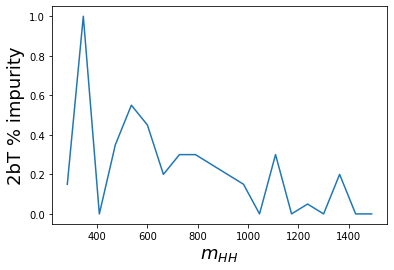

In [253]:
plt.plot(x, binned_best_fractions)
plt.xlabel(r'$m_{HH}$', fontsize =18)
plt.ylabel('2bT % impurity', fontsize = 18)

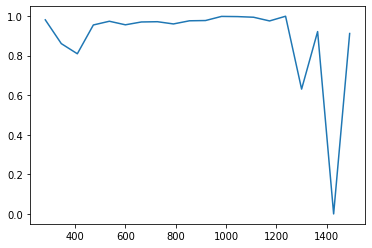

In [254]:
plt.plot(x, weight)

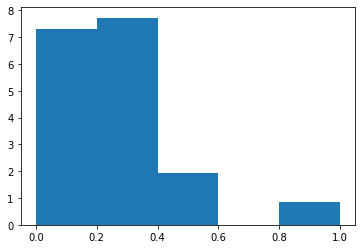

In [255]:
hf, be2, _ = plt.hist(binned_best_fractions, bins = 5, weights = weight)

In [256]:
hh.median_histogram(hf, be2)

array(0.14158969)

In [257]:
hh.mean_histogram(hf, be2)

0.268669796551843

In [60]:
diff = np.zeros((len(f4b), len(fractions)))
for i, _ in enumerate(f4b):
    for j, f in enumerate(fractions):
        
        diff[i][j] = np.abs(f4b[i] - (h2bS[i] + f*h2bT[i]))/f4b[i]
        

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


In [67]:
diff[5]

array([0.29485159, 0.28310026, 0.27134893, 0.25959761, 0.24784628,
       0.23609496, 0.22434363, 0.21259231, 0.20084098, 0.18908965,
       0.17733833, 0.165587  , 0.15383568, 0.14208435, 0.13033302,
       0.1185817 , 0.10683037, 0.09507905, 0.08332772, 0.07157639,
       0.05982507])

In [63]:
f4b

array([3.134e+03, 3.153e+03, 2.155e+03, 1.701e+03, 1.478e+03, 1.237e+03,
       1.058e+03, 9.360e+02, 8.910e+02, 8.030e+02, 7.360e+02, 7.010e+02,
       7.350e+02, 6.560e+02, 6.730e+02, 6.270e+02, 6.140e+02, 6.150e+02,
       5.370e+02, 5.340e+02, 5.000e+02, 4.510e+02, 4.510e+02, 4.120e+02,
       4.010e+02, 3.450e+02, 3.170e+02, 2.970e+02, 2.870e+02, 2.660e+02,
       2.340e+02, 1.910e+02, 1.740e+02, 1.740e+02, 1.760e+02, 1.580e+02,
       1.490e+02, 1.610e+02, 1.220e+02, 1.090e+02, 1.160e+02, 9.600e+01,
       9.800e+01, 9.700e+01, 7.200e+01, 7.900e+01, 6.800e+01, 5.600e+01,
       5.900e+01, 5.400e+01, 4.400e+01, 5.400e+01, 3.700e+01, 3.600e+01,
       2.900e+01, 2.700e+01, 3.100e+01, 2.700e+01, 2.100e+01, 2.200e+01,
       1.100e+01, 1.700e+01, 1.900e+01, 1.000e+01, 1.000e+01, 1.000e+01,
       8.000e+00, 1.500e+01, 9.000e+00, 1.100e+01, 6.000e+00, 4.000e+00,
       5.000e+00, 6.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 4.000e+00,
       3.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 

In [28]:
for i in range(len(be)-1):
    
    
    
    print(be[i], be[i]+1)

250.03597834960416 251.03597834960416
262.7685482630906 263.7685482630906
275.50111817657705 276.50111817657705
288.2336880900635 289.2336880900635
300.9662580035499 301.9662580035499
313.69882791703634 314.69882791703634
326.43139783052277 327.43139783052277
339.1639677440092 340.1639677440092
351.8965376574956 352.8965376574956
364.62910757098206 365.62910757098206
377.3616774844685 378.3616774844685
390.0942473979549 391.0942473979549
402.82681731144135 403.82681731144135
415.5593872249278 416.5593872249278
428.2919571384142 429.2919571384142
441.02452705190063 442.02452705190063
453.75709696538706 454.75709696538706
466.4896668788735 467.4896668788735
479.2222367923599 480.2222367923599
491.95480670584635 492.95480670584635
504.6873766193328 505.6873766193328
517.4199465328193 518.4199465328193
530.1525164463056 531.1525164463056
542.8850863597921 543.8850863597921
555.6176562732785 556.6176562732785
568.350226186765 569.350226186765
581.0827961002514 582.0827961002514
593.81536601

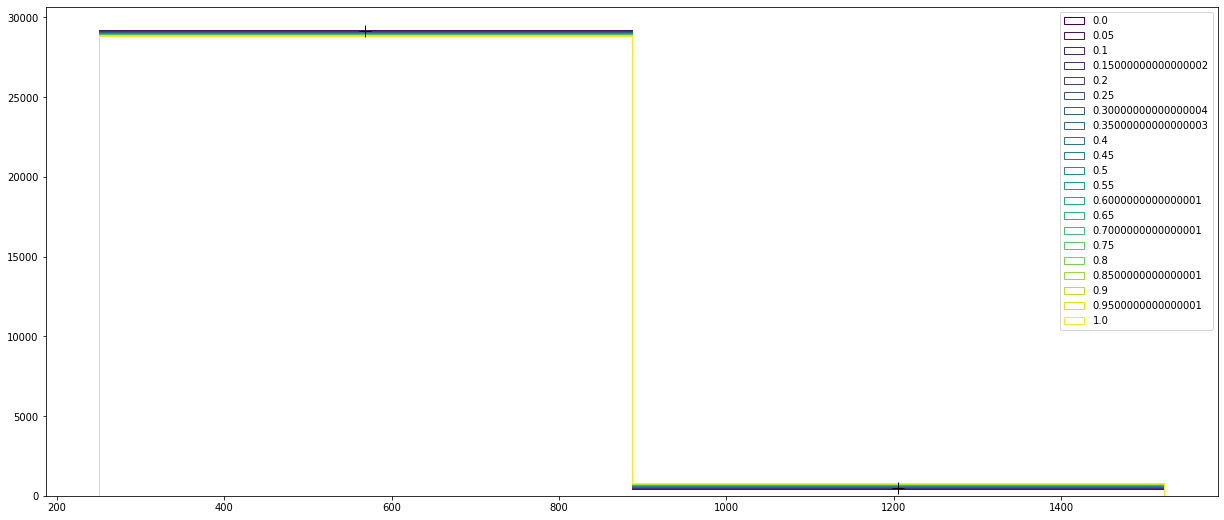

In [259]:
fig = plt.figure(figsize = (21,9))
f4b, be = np.histogram(CR[CR.ntag >=4].m_hh_cor, bins = 2)
x = hh.bin_midpoint(be)
plt.plot(x, f4b, 'k+', ms = 12)

N4b = np.sum(f4b)
mu = N4b/(len(CRS) + len(CRT))
muS = N4b/len(CRS)
muT = N4b/len(CRT)
mus = []
h2bM = np.zeros((len(fractions), len(f4b)))
for i, f in enumerate(fractions):
    M = u.mixSplitTogether(CRS, CRT, f = f)
    muM = N4b/len(M)
    mus.append(muM)
    h2bM[i], _ , _ = plt.hist(M.m_hh_cor, bins = be, color = cm[i], label = str(f), weights = muM * np.ones(len(M)), histtype = 'step')

#h2bS, _, _ = plt.hist(CRS.m_hh_cor, bins = be, label = 'S', weights = muS * np.ones(len(CRS)), histtype = 'step')
#h2bT, _, _ = plt.hist(CRT.m_hh_cor, bins = be, label = 'T', weights = muT * np.ones(len(CRT)), histtype = 'step')
plt.legend()